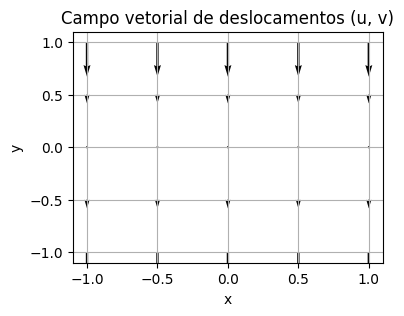

tensor([[8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06],
        [8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06, 8.0000e-06]],
       grad_fn=<DivBackward0>)


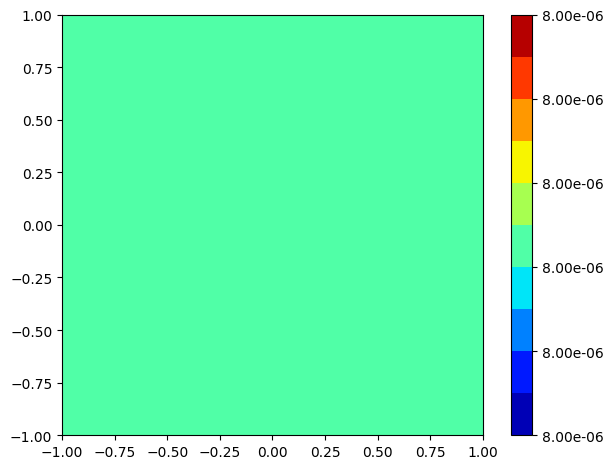

In [4]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

# Definição dos campos de deslocamento (u, v)
u = lambda x, y: 0 * x ** 2 * y ** 2  # Campo de deslocamento nulo na direção x
v = lambda x, y: -1.7004e-7 * y ** 2 + x ** 2 * y ** 2 * 0  # Campo de deslocamento na direção y

# Criação da malha espacial para análise
nx = 5  # Número de pontos na direção x
ny = 5  # Número de pontos na direção y
x = torch.linspace(-1, 1, nx, requires_grad=True)  # Coordenadas x com gradiente habilitado
y = torch.linspace(-1, 1, ny, requires_grad=True)  # Coordenadas y com gradiente habilitado
x, y = torch.meshgrid(x, y, indexing="ij")  # Cria malha 2D

# Amostragem do campo de deslocamento na malha
d = torch.cat((u(x, y).unsqueeze(0), v(x, y).unsqueeze(0)), 0)
# d[0] contém os deslocamentos u(x,y)
# d[1] contém os deslocamentos v(x,y)

# Visualização do campo de deslocamento com vetores
plt.figure(figsize=(4, 3))
plt.quiver(x.detach(), y.detach(), d[0, :, :].detach(), d[1, :, :].detach())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Campo vetorial de deslocamentos (u, v)')
plt.grid(True)
plt.show()

# Cálculo do gradiente do campo de deslocamento
dd_dx = torch.zeros((2, 2, nx, ny))  # Tensor para armazenar gradientes
dd_dx[0, 0] = grad(d[0], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]  # du/dx
dd_dx[0, 1] = grad(d[0], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]  # du/dy
dd_dx[1, 0] = grad(d[1], x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]  # dv/dx
dd_dx[1, 1] = grad(d[1], y, torch.ones_like(y), create_graph=True, retain_graph=True)[0]  # dv/dy

# Cálculo do tensor de deformações (parte simétrica do gradiente de deslocamentos)
eps = 0.5 * (dd_dx + dd_dx.permute((1, 0, 2, 3)))  # epsilon_ij = 0.5*(du_i/dx_j + du_j/dx_i)

# Propriedades do material e tensor constitutivo
E = 210000.0  # Módulo de Young (aço em MPa)
nu = 0.3      # Coeficiente de Poisson

# Tensor constitutivo para estado plano de tensão
C = torch.zeros((2, 2, 2, 2))  # Tensor de 4a ordem
C[0, 0, 0, 0] = 1.0
C[0, 0, 1, 1] = nu
C[1, 1, 0, 0] = nu
C[1, 1, 1, 1] = 1.0
C[0, 1, 0, 1] = (1.0 - nu) / 2.0
C = E / (1.0 - nu ** 2) * C  # Ajuste para estado plano de tensão

# Cálculo do tensor de tensões (Lei de Hooke)
sig = torch.tensordot(C, eps)  # sigma_ij = C_ijkl * epsilon_kl

# Verificação do equilíbrio (divergência do tensor de tensões)
dsig11_dx = grad(sig[0, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True)[0]  # d(sigma_xx)/dx
dsig12_dy = grad(sig[0, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True, allow_unused=True)[0]  # d(sigma_xy)/dy
dsig21_dx = grad(sig[1, 0], x, torch.ones_like(x), create_graph=True, retain_graph=True, allow_unused=True)[0]  # d(sigma_yx)/dx
dsig22_dy = grad(sig[1, 1], y, torch.ones_like(y), create_graph=True, retain_graph=True, allow_unused=True)[0]  # d(sigma_yy)/dy

# Forças de desequilíbrio (deveriam ser zero para solução exata)
f = torch.zeros((2, nx, ny))
f[0] = -dsig11_dx - dsig12_dy  # Força de desequilíbrio na direção x
f[1] = -dsig21_dx - dsig22_dy  # Força de desequilíbrio na direção y

# Cálculo da densidade a partir das forças de desequilíbrio
g = 9810  # Aceleração da gravidade (mm/s²)
rho = f[1] / g  # Densidade calculada
print(rho)  # Exibe os valores de densidade

# Visualização da distribuição de densidade
fig, ax = plt.subplots()
cp = ax.contourf(x.detach(), y.detach(), rho.detach(), levels=12, cmap=plt.cm.jet)
fig.colorbar(cp, format="%.2e")  # Barra de cores com notação científica
ax.set_aspect("equal")  # Mantém proporções iguais nos eixos
fig.tight_layout()
plt.show()